In [1]:
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from textblob import TextBlob
import torch
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.vader import SentimentIntensityAnalyzer

c:\Users\markham\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
# Load the data
test_data = pd.read_csv('data/processed_articles_2021.csv')
add_data = pd.read_csv('data/2021_add.csv')
# combine these two datasets
test_data = pd.concat([test_data, add_data], axis=0)
test_data['content'] = test_data['title'] + test_data['body']
test_data = test_data.drop(columns=['title','body'])
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.sort_values(by='date')
test_data['content'] = test_data['content'].apply(lambda x: ' '.join(x.split(',')))


In [3]:
# create a list of stop words
stop_words = set(stopwords.words('english'))
stop_words_list = ['aviva','company','shenzhen','kate','euros','emirate','dhabi','metre','asia','europe','shanghai','nichola','roger','msci','iran','states','italy','united','china','usa','us','america','american','americans','chinese','china','russia','russian','putin','vladimir','trump','donald','biden','joe','ukraine','ukrainian','ukrainians','ukraines','ukraine','say','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','mon','tue','wed','thu','fri','sat','sun','monday','tuesday','wednesday','thursday','friday','saturday','sunday','january','february','march','april','may','june','july','august','september','october','november','december','today','yesterday','tomorrow','week','month','year','time','day','weekend','morning','afternoon','evening','night','news','new','news']
list_numbers = ['eoi','name','houthi','uae','euro','yen','instead','liga','len','nhl','one','two','three','four','five','six','seven','eight','nine','ten','hundred','thousand','million','billion','trillion','first','second','third','eighted','series','hong','kong','new','york','los','angeles','san','francisco','las','vegas','san','diego','san','jose']
country_list = ['myanmar','robert','lebanon','iivi','william','zalando','olympic','country','world','africa','China', 'United States of America', 'United Kingdom', 'France', 'Germany', 'Japan', 'Russia', 'Australia', 'Canada', 'India', 'Brazil', 'Italy', 'Spain', 'South Korea', 'Mexico', 'Netherlands', 'Switzerland', 'Sweden', 'Norway', 'Denmark', 'Finland', 'Greece', 'Ireland', 'Portugal', 'Poland', 'Ukraine', 'Romania', 'Belgium', 'Austria', 'Turkey', 'Saudi Arabia', 'United Arab Emirates', 'Iran', 'Iraq', 'Israel', 'Egypt', 'South Africa', 'Argentina', 'Venezuela', 'Thailand', 'Malaysia', 'Singapore', 'Indonesia', 'Philippines', 'Pakistan', 'Bangladesh', 'Nigeria', 'Kenya', 'Tanzania', 'Uganda']
list_append = ["whose", "german", "saidsign", "ceo","exar","chos","sme", "vietnam", "gsk", "mori", "queen", "threeyear","would", "come", "also", "could", "edit", "include","pitch", "Britain", "Indian", "collin", "koo", "skorea", "men", "koo", "hub","bbva", "korea", "inc", "btp", "ntpcs", "telecom", "omi","jen","andre", "spac", "sabadell","faa", "unicredit", "city", "georgia", "puma", "philip", "england", "tokyo", "announce", "safrica", "andrea"]
stop_words.update(stop_words_list)
stop_words.update(list_numbers)
stop_words.update(country_list)
stop_words.update(list_append)
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word != 'nan']))
test_data['content_tokens'] = test_data['content'].apply(lambda x: x.split())

In [4]:
# delete the date with less than 60 samples, output the data which can be used for the recollection
start_date = '2021-01-01'
end_date = '2021-12-31'
test_data = test_data[(test_data['date'] >= start_date) & (test_data['date'] <= end_date)]
test_data
sample_counts = test_data['date'].value_counts()

# find the dates with less than 60 samples
invalid_dates = sample_counts[sample_counts < 30]
invalid_dates_df = invalid_dates.reset_index()
invalid_dates_df.columns = ['date', 'sample_count']
# output the dates with less than 60 samples to do the recollection
invalid_dates_df.to_csv('data/invalid_dates_sample_counts.csv', index=False)


# find the dates with more than 60 samples and keep them as the test data
valid_dates = sample_counts[sample_counts >= 30].index
test_data = test_data[test_data['date'].isin(valid_dates)]
test_data

,date,content,content_tokens
33732,2021-01-01,argentina grain inspector continue strike unio...,"[argentina, grain, inspector, continue, strike..."
33666,2021-01-01,man utds cavani peace accept sanctionmancheste...,"[man, utds, cavani, peace, accept, sanctionman..."
33667,2021-01-01,bitcoin touch record extend rallyyork price bi...,"[bitcoin, touch, record, extend, rallyyork, pr..."
33668,2021-01-01,lock berliner spark blaze home fireworkberlin ...,"[lock, berliner, spark, blaze, home, fireworkb..."
33669,2021-01-01,northern france truck cross custom border ukca...,"[northern, france, truck, cross, custom, borde..."
...,...,...,...
34260,2021-12-30,suspect militant kill soldier northern mali ar...,"[suspect, militant, kill, soldier, northern, m..."
34261,2021-12-30,egypt lending apps boost woman business ownerc...,"[egypt, lending, apps, boost, woman, business,..."
34262,2021-12-30,brazilian election affect petrobras price pled...,"[brazilian, election, affect, petrobras, price..."
34253,2021-12-30,tattoo target seek set good examplehong ban ge...,"[tattoo, target, seek, set, good, examplehong,..."


In [5]:
# Step 1: Train Word2Vec model on tokenized words
model = Word2Vec(sentences=test_data['content_tokens'], vector_size=80, window=6, min_count=2, workers=8) #use the loop function to find the best parameters


# Step 2: Compute TF-IDF weights for all words in the dataset
corpus = test_data['content'].tolist()  
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)
word2tfidf = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))

# Step 3: Identify high-frequency words per article
N = 15 # Number of top words per article, N also be found by the loop function
test_data['important_words'] = test_data['content_tokens'].apply(
    lambda tokens: sorted(
        set(tokens),  # Remove duplicates
        key=lambda x: word2tfidf.get(x, 0),  # Rank by TF-IDF score
        reverse=False  # Lower TF-IDF means higher frequency in this case
    )[:N]
)

# Step 4: Define a function to convert text to a weighted vector, use the word2vec model and the TF-IDF weights
def text_to_vector(text, model, word2tfidf):
    vectors = []
    weights = []
    for word in text:
        if word in model.wv:
            vectors.append(model.wv[word])
            weights.append(word2tfidf.get(word, 1.0))  # Default weight 1.0 if not in TF-IDF
    if not vectors:
        return np.zeros(model.vector_size)
    vectors = np.array(vectors)
    weights = np.array(weights) / sum(weights)  # Normalize weights
    return np.average(vectors, axis=0, weights=weights)

# Step 5: Convert important words to vectors
test_data['vector'] = test_data['important_words'].apply(lambda x: text_to_vector(x, model, word2tfidf))

# Step 6: Use the k-means algorithm to cluster the articles, split the data into two groups.
X = np.array(test_data['vector'].tolist())
num_clusters = 2  # Number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(X)
test_data['cluster_label'] = labels

# Display the updated DataFrame
test_data

,date,content,content_tokens,important_words,vector,cluster_label
33732,2021-01-01,argentina grain inspector continue strike unio...,"[argentina, grain, inspector, continue, strike...","[make, covid, high, end, next, work, top, pand...","[0.540901057945337, 1.3052982902113137, -0.029...",0
33666,2021-01-01,man utds cavani peace accept sanctionmancheste...,"[man, utds, cavani, peace, accept, sanctionman...","[take, use, point, share, accord, late, game, ...","[-0.41132576081341077, 1.077747043141187, 0.78...",0
33667,2021-01-01,bitcoin touch record extend rallyyork price bi...,"[bitcoin, touch, record, extend, rallyyork, pr...","[take, market, see, back, get, big, well, top,...","[0.6538900406747339, 1.587418250563418, 0.6086...",0
33668,2021-01-01,lock berliner spark blaze home fireworkberlin ...,"[lock, berliner, spark, blaze, home, fireworkb...","[last, take, covid, report, high, lead, use, f...","[-0.6155592858478208, 1.415512067076385, 0.413...",0
33669,2021-01-01,northern france truck cross custom border ukca...,"[northern, france, truck, cross, custom, borde...","[tell, big, global, early, continue, chief, bu...","[1.1712519702347193, 0.6508636186632809, -0.02...",0
...,...,...,...,...,...,...
34260,2021-12-30,suspect militant kill soldier northern mali ar...,"[suspect, militant, kill, soldier, northern, m...","[group, late, write, statement, force, south, ...","[-0.37985311207309397, 0.048800576371724635, -...",0
34261,2021-12-30,egypt lending apps boost woman business ownerc...,"[egypt, lending, apps, boost, woman, business,...","[make, take, report, end, people, rise, back, ...","[-0.48617161185679375, 0.4658060345919914, 0.7...",0
34262,2021-12-30,brazilian election affect petrobras price pled...,"[brazilian, election, affect, petrobras, price...","[tell, government, add, expect, rise, level, d...","[0.38520042281839506, 1.1811694576367946, 1.29...",0
34253,2021-12-30,tattoo target seek set good examplehong ban ge...,"[tattoo, target, seek, set, good, examplehong,...","[make, tell, add, get, level, well, set, team,...","[0.5055194480187336, 0.39240362616423563, 1.05...",1


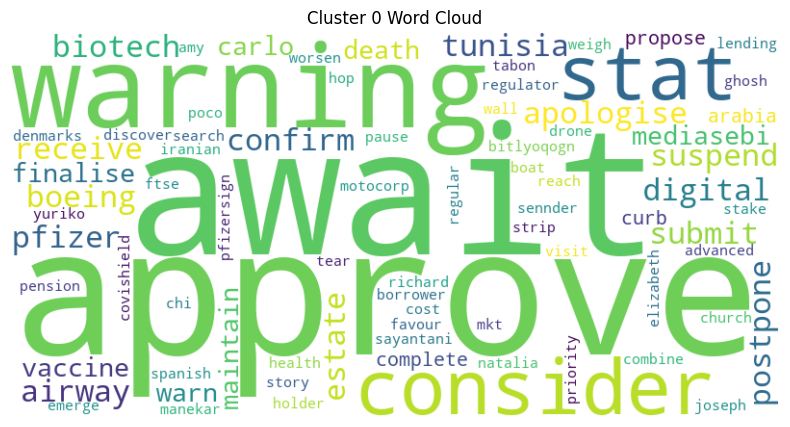

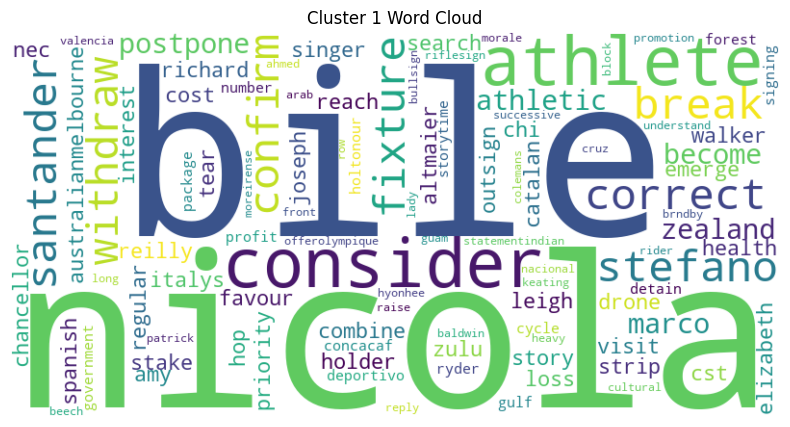

In [6]:
# Function to generate word cloud
def plot_word_cloud(text, title):
    """Generate and display a word cloud for the given text."""
    # Filter out stop words and non-alphabetic tokens
    words = ' '.join(word for word in text.split() if word.lower() not in stop_words and word.isalpha() and len(word) > 2)
    if not words.strip():
        print(f"No valid words for word cloud in {title}")
        return
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        max_words=100, 
        min_font_size=10,
        stopwords=stop_words
    ).generate(words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for each cluster
for cluster in range(num_clusters):
    # Merge important_words for the cluster into a single string, removing duplicates
    cluster_words = set(word for item in test_data[test_data['cluster_label'] == cluster]['important_words'].dropna() for word in item)
    cluster_text = ' '.join(cluster_words)
    if cluster_text.strip():
        plot_word_cloud(cluster_text, f'Cluster {cluster} Word Cloud')
    else:
        print(f"No data for Cluster {cluster} Word Cloud")

In [7]:
# Evaluate clustering effect by calculating silhouette score and Calinski-Harabasz index
if 'cluster_label' in test_data and len(set(test_data['cluster_label'])) > 1:
    X = np.array(test_data['vector'].tolist())  # Assuming 'vector' is from the Word2Vec/KMeans pipeline
    labels = test_data['cluster_label'].values
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Calinski-Harabasz Index: {ch_score:.3f}")
else:
    print("Unable to calculate clustering metrics: Either no 'cluster_label' column or fewer than 2 clusters.")

Silhouette Score: 0.141
Calinski-Harabasz Index: 6502.785


In [8]:
# Sentiment Analysis
# Method 1: Use VADER to analyze sentiment of important words in each cluster
test_data['date'] = pd.to_datetime(test_data['date'])
grouped = test_data.groupby('date')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
# Store daily sentiment results for each cluster
sentiment_results = []

for date, group in grouped:
    for cluster in range(num_clusters):
        cluster_data = group[group['cluster_label'] == cluster]
        sentiment_scores = []

        for important_words in cluster_data['important_words'].dropna():
            if isinstance(important_words, list):
                words = [word for word in important_words if word.lower() not in stop_words and word.isalpha() and len(word) > 2]
            else:
                continue  
            
            if not words:
                continue  

            # calculate word weights based on TF-IDF scores
            word_weights = np.array([word2tfidf.get(word, 1.0) for word in words])
            
            # Normalize word weights to sum to 1
            if word_weights.sum() == 0:
                word_weights = np.ones_like(word_weights) / len(word_weights)
            else:
                word_weights /= word_weights.sum()

            text = " ".join(words)

            try:
                sentiment = analyzer.polarity_scores(text)
                compound_score = sentiment['compound']
                positive_score = sentiment['pos']
                negative_score = sentiment['neg']
                neutral_score = sentiment['neu']

                # Calculate weighted sentiment scores
                weighted_sentiment = {
                    'compound': compound_score * word_weights.sum(),
                    'positive': positive_score * word_weights.sum(),
                    'negative': negative_score * word_weights.sum(),
                    'neutral': neutral_score * word_weights.sum()
                }

                sentiment_scores.append(weighted_sentiment)
            
            except Exception as e:
                print(f"Error processing text for date {date}, cluster {cluster}: {text[:50]}..., Error: {e}")
                continue


        # Calculate average sentiment scores
        if sentiment_scores:
            avg_sentiment = {
                'compound': np.average([s['compound'] for s in sentiment_scores], weights=[word_weights.sum()] * len(sentiment_scores)),
                'positive': np.average([s['positive'] for s in sentiment_scores], weights=[word_weights.sum()] * len(sentiment_scores)),
                'negative': np.average([s['negative'] for s in sentiment_scores], weights=[word_weights.sum()] * len(sentiment_scores)),
                'neutral': np.average([s['neutral'] for s in sentiment_scores], weights=[word_weights.sum()] * len(sentiment_scores))
            }

            sentiment_results.append({
                'date': date,
                'cluster': cluster,
                'sentiment_score': avg_sentiment['compound'],
                'positive_score': avg_sentiment['positive'],
                'negative_score': avg_sentiment['negative'],
                'neutral_score': avg_sentiment['neutral'],
                'num_samples': len(sentiment_scores)
            })
        else:
            sentiment_results.append({
                'date': date,
                'cluster': cluster,
                'sentiment_score': 0.0,
                'positive_score': 0.0,
                'negative_score': 0.0,
                'neutral_score': 0.0,
                'num_samples': 0
            })

# Create DataFrame from sentiment results
vade_sentiment_df = pd.DataFrame(sentiment_results)

# Print results
print("\nSentiment Analysis Results:")
vade_sentiment_df


Sentiment Analysis Results:


,date,cluster,sentiment_score,positive_score,negative_score,neutral_score,num_samples
0,2021-01-01,0,0.267522,0.143508,0.016762,0.839746,63
1,2021-01-01,1,0.428469,0.195500,0.029577,0.774962,26
2,2021-01-02,0,0.179564,0.120803,0.031947,0.847263,76
3,2021-01-02,1,0.403457,0.210000,0.039092,0.750969,65
4,2021-01-03,0,0.156680,0.112632,0.038080,0.849287,87
...,...,...,...,...,...,...,...
681,2021-12-28,1,0.421826,0.216298,0.037000,0.746723,47
682,2021-12-29,0,0.215539,0.143797,0.041551,0.814623,69
683,2021-12-29,1,0.269145,0.133500,0.024950,0.841550,20
684,2021-12-30,0,0.152939,0.115351,0.036054,0.848581,74


In [9]:
# Save the sentiment analysis results to a CSV file
vade_sentiment_df.to_csv('result/vade_sentiment_analysis_result.csv', index=False)

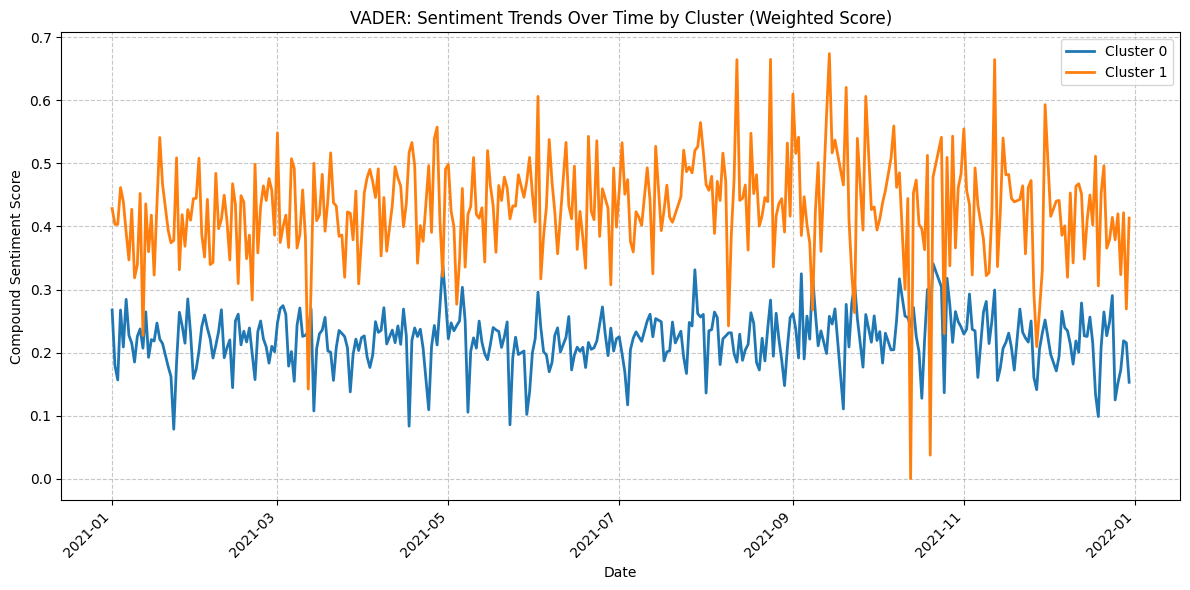

In [10]:
# Visualize sentiment scores over time for each cluster
plt.figure(figsize=(12, 6))
for cluster in range(num_clusters):
    cluster_data = vade_sentiment_df[vade_sentiment_df['cluster'] == cluster]
    plt.plot(cluster_data['date'], cluster_data['sentiment_score'], label=f'Cluster {cluster}', marker=None, linestyle='-', linewidth=2)

plt.title('VADER: Sentiment Trends Over Time by Cluster (Weighted Score)')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')
plt.legend()
plt.xticks(rotation=45, ha='right')  
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
# Method 2: Use FinBERT for sentiment analysis
test_data['date'] = pd.to_datetime(test_data['date'])
grouped = test_data.groupby('date')

# Load FinBERT model and tokenizer
model_name = "yiyanghkust/finbert-tone"  # FinBERT model fine-tuned for financial sentiment
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a sentiment analysis pipeline with FinBERT
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True  # Return probabilities for all labels
)

# Function to process text and get FinBERT sentiment
def get_finbert_sentiment(text, max_length=512):
    """Get sentiment scores using FinBERT, handling text truncation if necessary."""
    if not text or not isinstance(text, str):
        return {'positive': 0.0, 'negative': 0.0, 'neutral': 0.0}
    
    # Truncate text if longer than max_length to avoid errors
    if len(text.split()) > max_length:
        text = " ".join(text.split()[:max_length])
    
    try:
        result = sentiment_analyzer(text)[0]  # Get the first (and only) result
        scores = {item['label'].lower(): item['score'] for item in result}
        # Ensure all labels (positive, negative, neutral) are present
        return {
            'positive': scores.get('positive', 0.0),
            'negative': scores.get('negative', 0.0),
            'neutral': scores.get('neutral', 0.0)
        }
    except Exception as e:
        print(f"Error processing text with FinBERT: {text[:50]}..., Error: {e}")
        return {'positive': 0.0, 'negative': 0.0, 'neutral': 0.0}

# Store daily sentiment results for each cluster
sentiment_results = []

for date, group in grouped:
    for cluster in range(num_clusters):
        cluster_data = group[group['cluster_label'] == cluster]
        sentiment_scores = []

        for important_words in cluster_data['important_words'].dropna():
            # Ensure important_words is a list; if it's a string, split it
            if isinstance(important_words, str):
                words = [word for word in important_words.split() if word.lower() not in stop_words and word.isalpha() and len(word) > 2]
            elif isinstance(important_words, list):
                words = [word for word in important_words if word.lower() not in stop_words and word.isalpha() and len(word) > 2]
            else:
                continue  # Skip invalid data

            if not words:
                continue  # Skip if no valid words after filtering

            text = " ".join(words)

            # Get sentiment scores using FinBERT
            sentiment = get_finbert_sentiment(text)
            sentiment_scores.append(sentiment)

        # Calculate average sentiment scores
        if sentiment_scores:
            avg_sentiment = {
                'positive': np.mean([s['positive'] for s in sentiment_scores]),
                'negative': np.mean([s['negative'] for s in sentiment_scores]),
                'neutral': np.mean([s['neutral'] for s in sentiment_scores])
            }
            # Calculate a compound-like score (e.g., positive - negative)
            compound_score = avg_sentiment['positive'] - avg_sentiment['negative']
            sentiment_results.append({
                'date': date,
                'cluster': cluster,
                'sentiment_score': compound_score,  # Use positive - negative as compound score
                'positive_score': avg_sentiment['positive'],
                'negative_score': avg_sentiment['negative'],
                'neutral_score': avg_sentiment['neutral'],
                'num_samples': len(sentiment_scores)
            })
        else:
            sentiment_results.append({
                'date': date,
                'cluster': cluster,
                'sentiment_score': 0.0,
                'positive_score': 0.0,
                'negative_score': 0.0,
                'neutral_score': 0.0,
                'num_samples': 0
            })

# Create DataFrame from sentiment results
sentiment_df = pd.DataFrame(sentiment_results)

# Print results
print("\nSentiment Analysis Results (FinBERT):")
sentiment_df

Device set to use cpu
c:\Users\markham\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



Sentiment Analysis Results (FinBERT):


,date,cluster,sentiment_score,positive_score,negative_score,neutral_score,num_samples
0,2021-01-01,0,0.227013,0.227638,0.000625,0.771738,63
1,2021-01-01,1,0.351695,0.392889,0.041194,0.565917,26
2,2021-01-02,0,0.101838,0.104420,0.002582,0.892998,76
3,2021-01-02,1,0.144014,0.178303,0.034290,0.787407,65
4,2021-01-03,0,0.151992,0.169725,0.017733,0.812543,87
...,...,...,...,...,...,...,...
681,2021-12-28,1,0.292651,0.316515,0.023865,0.659620,47
682,2021-12-29,0,0.225042,0.259885,0.034843,0.705272,69
683,2021-12-29,1,0.299076,0.300742,0.001666,0.697592,20
684,2021-12-30,0,0.241059,0.262373,0.021314,0.716314,74


In [12]:
# Save the sentiment analysis results to a CSV file
sentiment_df.to_csv('result/finbert_sentiment_analysis_results.csv', index=False)

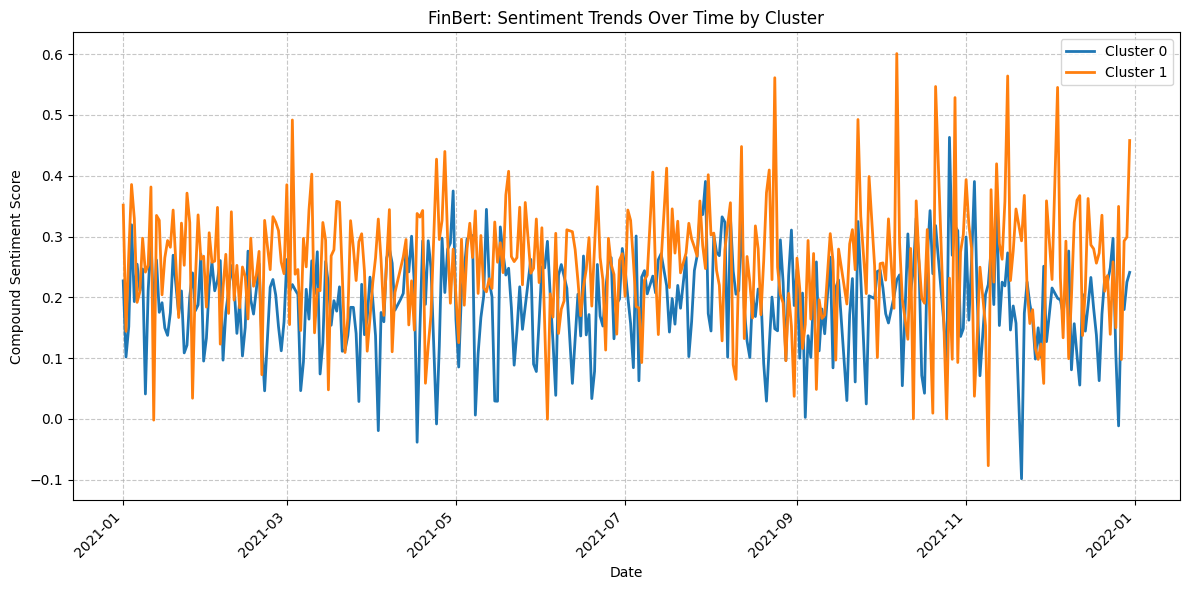

In [13]:
# Visualize sentiment scores over time for each cluster
plt.figure(figsize=(12, 6))
for cluster in range(num_clusters):
    cluster_data = sentiment_df[sentiment_df['cluster'] == cluster]
    plt.plot(cluster_data['date'], cluster_data['sentiment_score'], label=f'Cluster {cluster}', marker=None, linestyle='-', linewidth=2)
plt.title('FinBert: Sentiment Trends Over Time by Cluster')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()